In [1]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk

Using TensorFlow backend.


In [3]:
# data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv")
data=pd.read_csv("..\\..\\Data\\model_training\\100000_samples_giga.csv", nrows=100000)
data[['Text','Summary']]

,Text,Summary
0,"this weekend 's group of eight summit in russia may be one of the last chances for the international community to revive stalled world trade talks , prime minister tony blair said wednesday .",britain 's blair says g-# summit may be one of last chances to revive wto talks
1,one of india 's biggest christian groups tuesday demanded revocation of a death sentence on a ##-year-old boy for insulting islam in pakistan .,indian christian group protests pakistani court ruling
2,"the internet boom is bringing sweeping demographic changes to silicon valley , according to an annual report card for the region , which shows that the number of nonwhite residents surpassed white...",influx of new immigrants found in silicon valley
3,india 's parliament reopened monday to consider the national budget as opposition parties planned a united attack on the government for failing to control hindu hard-liners who want to build a tem...,budget session of indian parliament opens on a stormy note
4,"taiwan 's small and medium-sized exporters that sign up for or renew <unk> website memberships will be offered discounted dun &amp; bradstreet -lrb- <unk> -rrb- accreditation , the taiwan external...",new <unk> members offered discounted <unk> logos
...,...,...
99995,malaysia 's second biggest cell phone operator maxis on wednesday began trials of its high-speed third-generation -lrb- #g -rrb- mobile services ahead of the commercial launch slated for the end o...,malaysia 's maxis begins trial #g services
99996,"a booby trap bomb was planted on the car of an official of the <unk> sinn fein party on saturday , police said .",second car bomb planted on sinn fein car
99997,"the death toll of israeli soldiers in an attack by hezbollah along the northern border wednesday morning rose to eight , while two soldiers were taken hostages , israel defense forces -lrb- idf -r...",eight israeli soldiers killed in hezbollah attack
99998,sporadic fighting between government troops and muslim rebels in the southern philippines persisted friday as each side claimed it inflicted heavy casualties and islamic countries stepped up media...,philippine troops muslims rebels each claim upper hand in renewed fighting


In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)
data

,Text,Summary
0,"this weekend 's group of eight summit in russia may be one of the last chances for the international community to revive stalled world trade talks , prime minister tony blair said wednesday .",britain 's blair says g-# summit may be one of last chances to revive wto talks
1,one of india 's biggest christian groups tuesday demanded revocation of a death sentence on a ##-year-old boy for insulting islam in pakistan .,indian christian group protests pakistani court ruling
2,"the internet boom is bringing sweeping demographic changes to silicon valley , according to an annual report card for the region , which shows that the number of nonwhite residents surpassed white...",influx of new immigrants found in silicon valley
3,india 's parliament reopened monday to consider the national budget as opposition parties planned a united attack on the government for failing to control hindu hard-liners who want to build a tem...,budget session of indian parliament opens on a stormy note
4,"taiwan 's small and medium-sized exporters that sign up for or renew <unk> website memberships will be offered discounted dun &amp; bradstreet -lrb- <unk> -rrb- accreditation , the taiwan external...",new <unk> members offered discounted <unk> logos
...,...,...
99995,malaysia 's second biggest cell phone operator maxis on wednesday began trials of its high-speed third-generation -lrb- #g -rrb- mobile services ahead of the commercial launch slated for the end o...,malaysia 's maxis begins trial #g services
99996,"a booby trap bomb was planted on the car of an official of the <unk> sinn fein party on saturday , police said .",second car bomb planted on sinn fein car
99997,"the death toll of israeli soldiers in an attack by hezbollah along the northern border wednesday morning rose to eight , while two soldiers were taken hostages , israel defense forces -lrb- idf -r...",eight israeli soldiers killed in hezbollah attack
99998,sporadic fighting between government troops and muslim rebels in the southern philippines persisted friday as each side claimed it inflicted heavy casualties and islamic countries stepped up media...,philippine troops muslims rebels each claim upper hand in renewed fighting


In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [8]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [9]:
for i in range(5,10):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: john stamos heard starring opposite gina gershon broadway fall beyond happy
Summary: _START_ stamos and gershon say hello to bye bye birdie  _END_


Review: chrysler filed bankruptcy protection thursday announced temporarily halt vehicle production completes deal italian carmaker fiat designed revive tattered fortunes
Summary: _START_ chrysler files for bankruptcy protection  _END_


Review: chinese namibian governments today inked agreement economic technical cooperation effort promote bilateral economic trade ties
Summary: _START_ china namibia sign agreement  _END_


Review: reform security council united nations make organization democratic representative body guido tella minister foreign affairs said today
Summary: _START_ argentina on reform of un security council  _END_


Review: french firm laboratoires unit pharmaceutical group sold britain boots healthcare international million francs announced friday
Summary: _START_ unk laboratories sold to britain boots healthcare 

In [10]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

<Figure size 640x480 with 2 Axes>

In [11]:
max_len_text=35 
max_len_summary=16
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [12]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1
x_voc_size

50712

In [13]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1
y_voc_size

30736

In [14]:
# # GLOVE_DIR = path for glove.6B.100d.txt
# def glove_dictionary(GLOVE_DIR, glove_dimension):
#     embeddings_index = {}
#     f = open(os.path.join(GLOVE_DIR, 'glove.6B.'+str(glove_dimension)+'d.txt'))
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     f.close()
#     return embeddings_index

In [15]:
# GLOVE_DIR='..\\Data\\word_embeddings'
# glove_dimension=200
# embeddings_index = glove_dictionary(GLOVE_DIR=GLOVE_DIR, glove_dimension=glove_dimension)
# print('Found %s word vectors.' % len(embeddings_index))

In [16]:
glove_dir='..\\..\\Data\\word_embeddings'
glove_dimension=200
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.'+str(glove_dimension)+'d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
# from load_glove_embeddings import load_glove_embeddings # local function from .py file
# glove_dimension = 100
# import time
# timer_start = time.time()
# # word2index, embedding_matrix = load_glove_embeddings('Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
# word2index, embedding_matrix = load_glove_embeddings('../Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
# del embedding_matrix
# print('Found %s word vectors.' % len(word2index))
# print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
# del timer_start
# embeddings_index=word2index
# del word2index

In [18]:
from itertools import islice
list(islice(embeddings_index.items(), 1))

[('the',
  array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
          3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
          1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
         -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
          4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
          7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
          1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
         -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
         -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
          6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
         -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
          8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
          1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
          1.4379e-01, -1.2325

In [19]:
word_index = x_tokenizer.word_index
local_embedding_matrix = np.zeros((len(word_index) + 1, glove_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        local_embedding_matrix[i] = embedding_vector
local_embedding_matrix.shape

(50712, 200)

In [20]:
local_embedding_matrix[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 200)      10142400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 35, 400), (N 961600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

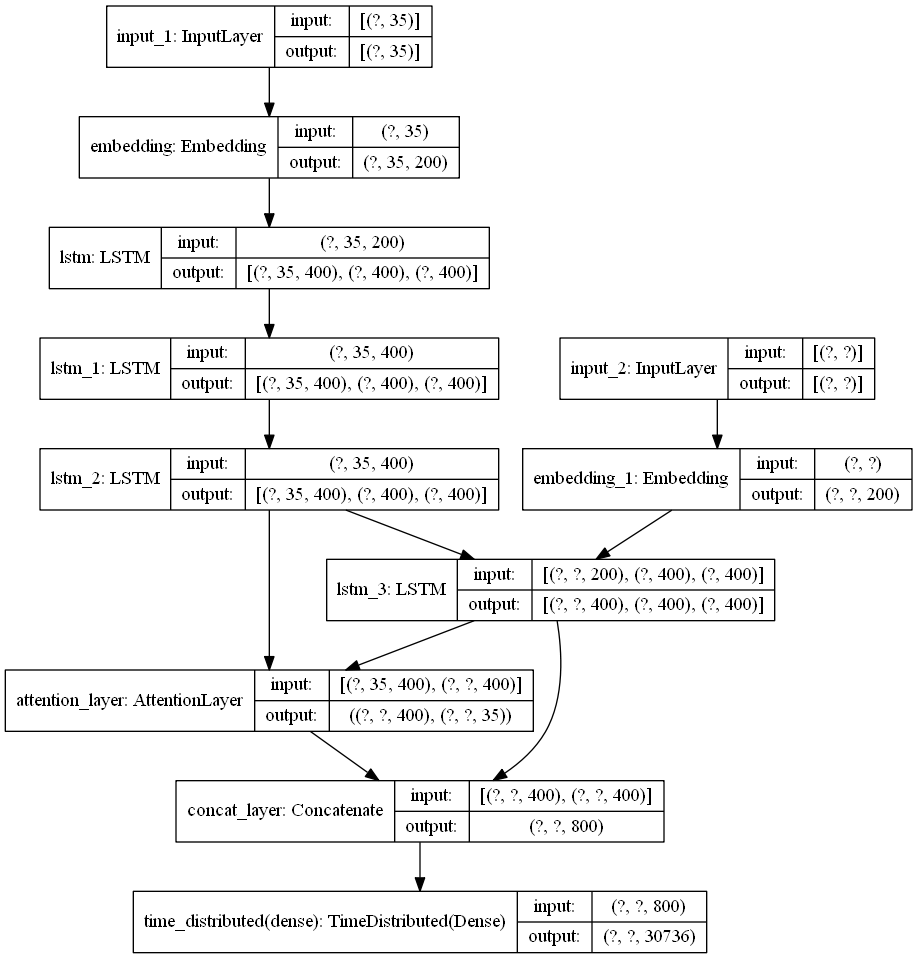

In [21]:
from attention import AttentionLayer
from keras import backend as K
K.clear_session()
latent_dim = 400

# Encoder 
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, glove_dimension, 
                    weights=[local_embedding_matrix],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, glove_dimension, 
                          weights=[local_embedding_matrix],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=20,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]],
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 89416 samples, validate on 9936 samples
Epoch 1/20
89416/89416 [==============================] - 5138s 57ms/sample - loss: 3.9980 - val_loss: 3.5606
Epoch 2/20
89416/89416 [==============================] - 5138s 57ms/sample - loss: 3.4815 - val_loss: 3.3307
Epoch 3/20
89416/89416 [==============================] - 5151s 58ms/sample - loss: 3.2491 - val_loss: 3.2015
Epoch 4/20
89416/89416 [==============================] - 5157s 58ms/sample - loss: 3.0823 - val_loss: 3.1170
Epoch 5/20
89416/89416 [==============================] - 5135s 57ms/sample - loss: 2.9483 - val_loss: 3.0643
Epoch 6/20
89416/89416 [==============================] - 5157s 58ms/sample - loss: 2.8290 - val_loss: 3.0355
Epoch 7/20
89416/89416 [==============================] - 5147s 58ms/sample - loss: 2.7210 - val_loss: 3.0305
Epoch 8/20
 3200/89416 [>.............................] - ETA: 1:21:29 - loss: 2.5066WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Avail

KeyboardInterrupt: 

In [23]:
# from matplotlib import pyplot 
# pyplot.plot(history.history['loss'], label='train') 
# pyplot.plot(history.history['val_loss'], label='test') 
# pyplot.legend() 
# pyplot.show()

In [24]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

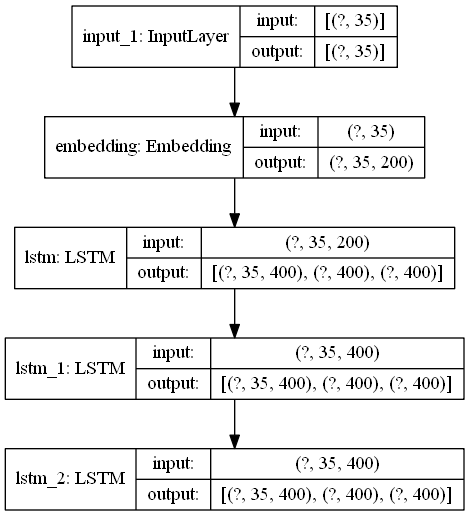

In [25]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='model.png', show_shapes=True)


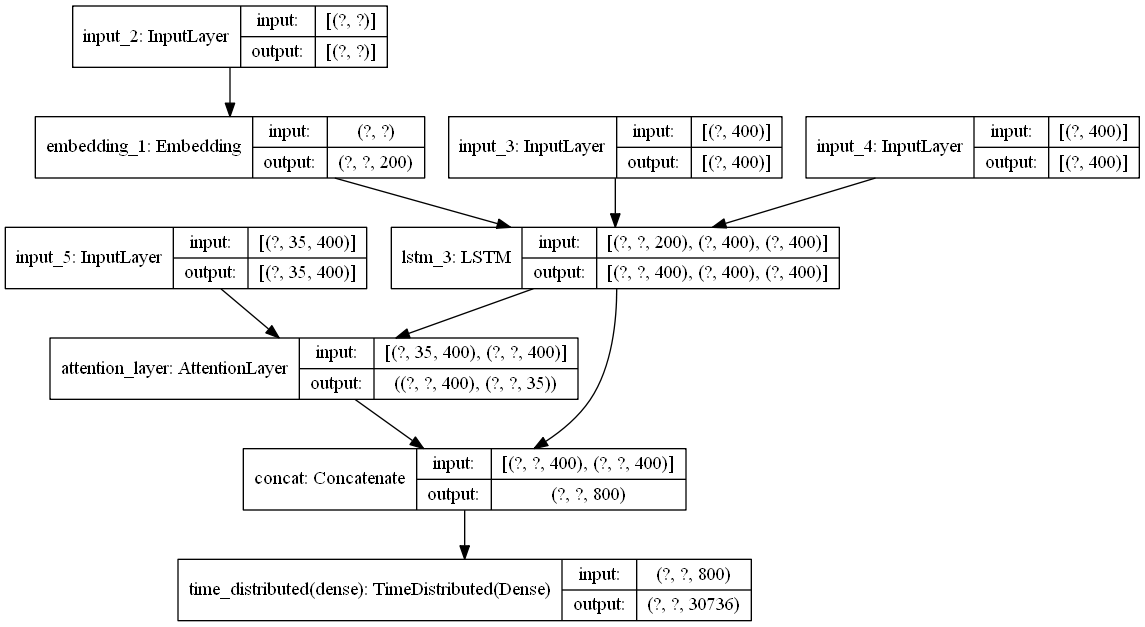

In [26]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])
tf.keras.utils.plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [28]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [29]:
for i in range(30):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: australian labor party chief mark latham stressed security issues met political business leaders papua new guinea thursday first overseas trip since installed opposition leader 
Original summary: australian opposition leader meets png leaders 
Predicted summary:  australian leader calls for talks with pacific


Review: protestant gang northern ireland surrendered guns disarmament officials move appears stirred tensions within ranks ulster defense association 
Original summary: protestant gang surrenders some guns in northern ireland but value of move disputed 
Predicted summary:  northern ireland leader says he is still peace


Review: white ulee mosque defiantly tide line worst hit stretch indonesia devastated coast nearly pristine despite buffeting last month tsunami turned villages behind dead zone corpses splintered wood 
Original summary: mosques stand alone amid indonesia tsunami destruction see divine help 
Predicted summary:  indonesia tsunami volcano off in indonesia



Predicted summary:  hamas militants gaza truce in gaza city


